# Integration of 2D functions using the Legendre-Gauss/Lobatto-Gauss quadrature

In [4]:
import os
import sys
sys.path.insert(0, os.path.abspath('../'))

from matplotlib import pyplot as plt
import numpy as np
import arrayfire as af

from dg_maxwell import params
from dg_maxwell import utils
from dg_maxwell import lagrange
from dg_maxwell import wave_equation_2d as w2d

af.set_backend(params.backend)

plt.rcParams['figure.figsize']     = 12, 7.5
plt.rcParams['lines.linewidth']    = 1.5
plt.rcParams['font.family']        = 'serif'
plt.rcParams['font.weight']        = 'bold'
plt.rcParams['font.size']          = 20  
plt.rcParams['font.sans-serif']    = 'serif'
plt.rcParams['text.usetex']        = True
plt.rcParams['axes.linewidth']     = 1.5
plt.rcParams['axes.titlesize']     = 'medium'
plt.rcParams['axes.labelsize']     = 'medium'

plt.rcParams['xtick.major.size']   = 8
plt.rcParams['xtick.minor.size']   = 4
plt.rcParams['xtick.major.pad']    = 8
plt.rcParams['xtick.minor.pad']    = 8
plt.rcParams['xtick.color']        = 'k'
plt.rcParams['xtick.labelsize']    = 'medium'
plt.rcParams['xtick.direction']    = 'in'    

plt.rcParams['ytick.major.size']   = 8
plt.rcParams['ytick.minor.size']   = 4
plt.rcParams['ytick.major.pad']    = 8
plt.rcParams['ytick.minor.pad']    = 8
plt.rcParams['ytick.color']        = 'k'
plt.rcParams['ytick.labelsize']    = 'medium'
plt.rcParams['ytick.direction']    = 'in'
plt.rcParams['text.usetex']        = True
plt.rcParams['text.latex.unicode'] = True

In [24]:
N_LGL = 16
xi_LGL  = lagrange.LGL_points(N_LGL)
eta_LGL = lagrange.LGL_points(N_LGL)
Xi, Eta = utils.af_meshgrid(xi_LGL, eta_LGL)

_, Li_xi  = lagrange.lagrange_polynomials(xi_LGL)
_, Lj_eta = lagrange.lagrange_polynomials(eta_LGL)

Li_xi  = af.np_to_af_array(Li_xi)
Lj_eta = af.np_to_af_array(Lj_eta)
Lp_xi  = Li_xi.copy()
Lq_eta = Lj_eta.copy()

/home/ubermensch/.local/anaconda3/lib/python3.6/site-packages/numpy/lib/polynomial.py:1193: FutureWarning: In the future extra properties will not be copied across when constructing one poly1d from another
  other = poly1d(other)
/home/ubermensch/.local/anaconda3/lib/python3.6/site-packages/numpy/lib/polynomial.py:1220: FutureWarning: In the future extra properties will not be copied across when constructing one poly1d from another
  other = poly1d(other)


In [25]:
Li_Lp = utils.poly1d_product(Li_xi, Lp_xi)
Lj_Lq = utils.poly1d_product(Lj_eta, Lq_eta)

In [69]:
def function(x, y):
#     return af.sin(4 * ((x - 0.3)**2 + (y + 0.3)**2)) \
#          + af.cos(4 * ((x - 0.3)**2 + (y + 0.3)**2))
#     return af.sin(4 * ((x - 0.3)**2 + (y + 0.3)**2))
#     return np.e**(-(x**2 + y**2) / 0.6**2)
#     return np.e**(-(0.5 * x**2 + 2. * y**2) / 0.6**2)
#     return af.sin(((x - 0.3)**2 + (y + 0.3)**2)) ** 4
#     return (af.sin((x**2 + y**2)) * af.cos((x**2 + y**2)))**4
    return np.e**(-(x + y) / 0.6**2)

/home/ubermensch/.local/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


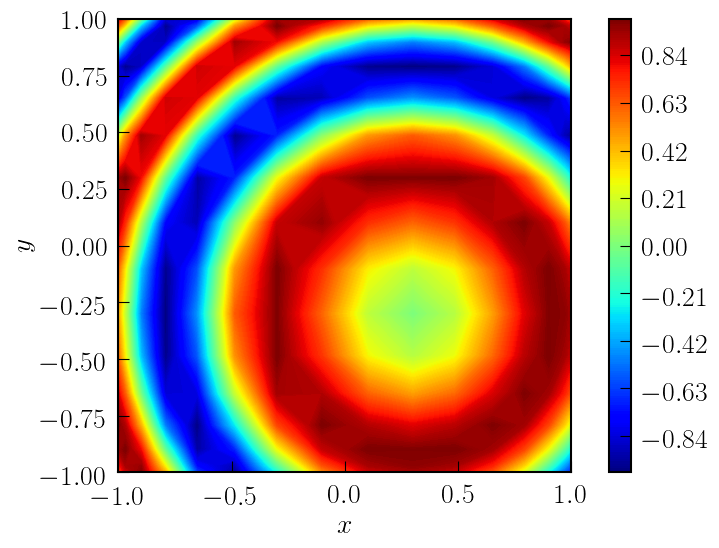

In [26]:
function_ij = function(Xi, Eta)
function_ij_tile = af.flat(function_ij)

# print(gaussian_xy_ij)
plt.contourf(np.array(Xi), np.array(Eta), np.array(function_ij),
             200, cmap = 'jet')

plt.axes().set_aspect('equal')
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.colorbar()

# plt.savefig('u_init.png')
plt.show()

In [27]:
# print(Lq_eta)
Lp_xi_tile = af.reorder(Lq_eta, d0 = 2, d1 = 0, d2 = 1)
Lp_xi_tile = af.tile(Lp_xi_tile, d0 = N_LGL)
Lp_xi_tile = af.moddims(Lp_xi_tile, d0 = N_LGL * N_LGL, d1 = 1, d2 = N_LGL)
Lp_xi_tile = af.reorder(Lp_xi_tile, d0 = 0, d1 = 2, d2 = 1)

Lq_eta_tile = af.reorder(Lq_eta, d0 = 0, d1 = 2, d2 = 1)
Lq_eta_tile = af.tile(Lq_eta_tile, d0 = N_LGL)
Lq_eta_tile = af.reorder(Lq_eta_tile, d0 = 0, d1 = 2, d2 = 1)

In [28]:
integral = function_ij_tile * utils.integrate_2d(Lp_xi_tile, Lq_eta_tile, order = 9, scheme = 'gauss')
integral = af.sum(integral, dim = 0)
af.display(integral, 14)

In [70]:
# Convergence test for integrate function

error = []
# ref_integral = 1.29963209362073 # function 0
# ref_integral = 0.945143816408656 # function 1
# ref_integral = 1.08968731296967 # function 2
# ref_integral = 1.02199637574522
# ref_integral = 1.33783253647835
# ref_integral = 0.108234186899320
ref_integral = 33.2650147380588
for n_LGL in np.arange(5, 24):
    n_LGL = int(n_LGL)
    print(n_LGL)
    xi_LGL  = lagrange.LGL_points(n_LGL)
    eta_LGL = lagrange.LGL_points(n_LGL)
    Xi, Eta = utils.af_meshgrid(xi_LGL, eta_LGL)

    _, Li_xi  = lagrange.lagrange_polynomials(xi_LGL)
    _, Lj_eta = lagrange.lagrange_polynomials(eta_LGL)

    Li_xi  = af.np_to_af_array(Li_xi)
    Lj_eta = af.np_to_af_array(Lj_eta)
    Lp_xi  = Li_xi.copy()
    Lq_eta = Lj_eta.copy()

    Li_Lp = utils.poly1d_product(Li_xi, Lp_xi)
    Lj_Lq = utils.poly1d_product(Lj_eta, Lq_eta)

    function_ij = function(Xi, Eta)
    function_ij_tile = af.flat(function_ij)


    # print(Lq_eta)
    Lp_xi_tile = af.reorder(Lq_eta, d0 = 2, d1 = 0, d2 = 1)
    Lp_xi_tile = af.tile(Lp_xi_tile, d0 = n_LGL)
    Lp_xi_tile = af.moddims(Lp_xi_tile, d0 = n_LGL * n_LGL, d1 = 1, d2 = n_LGL)
    Lp_xi_tile = af.reorder(Lp_xi_tile, d0 = 0, d1 = 2, d2 = 1)

    Lq_eta_tile = af.reorder(Lq_eta, d0 = 0, d1 = 2, d2 = 1)
    Lq_eta_tile = af.tile(Lq_eta_tile, d0 = n_LGL)
    Lq_eta_tile = af.reorder(Lq_eta_tile, d0 = 0, d1 = 2, d2 = 1)


    integral = function_ij_tile * utils.integrate_2d(Lp_xi_tile, Lq_eta_tile, order = 9, scheme = 'gauss')
    integral = af.sum(integral, dim = 0)
    error.append(np.array(af.abs(integral - ref_integral))[0])
    
error = np.array(error)

5
6
7
8
9
10
11
12
13
14


/home/ubermensch/.local/anaconda3/lib/python3.6/site-packages/numpy/lib/polynomial.py:1193: FutureWarning: In the future extra properties will not be copied across when constructing one poly1d from another
  other = poly1d(other)
/home/ubermensch/.local/anaconda3/lib/python3.6/site-packages/numpy/lib/polynomial.py:1220: FutureWarning: In the future extra properties will not be copied across when constructing one poly1d from another
  other = poly1d(other)


15
16
17
18
19
20
21
22
23


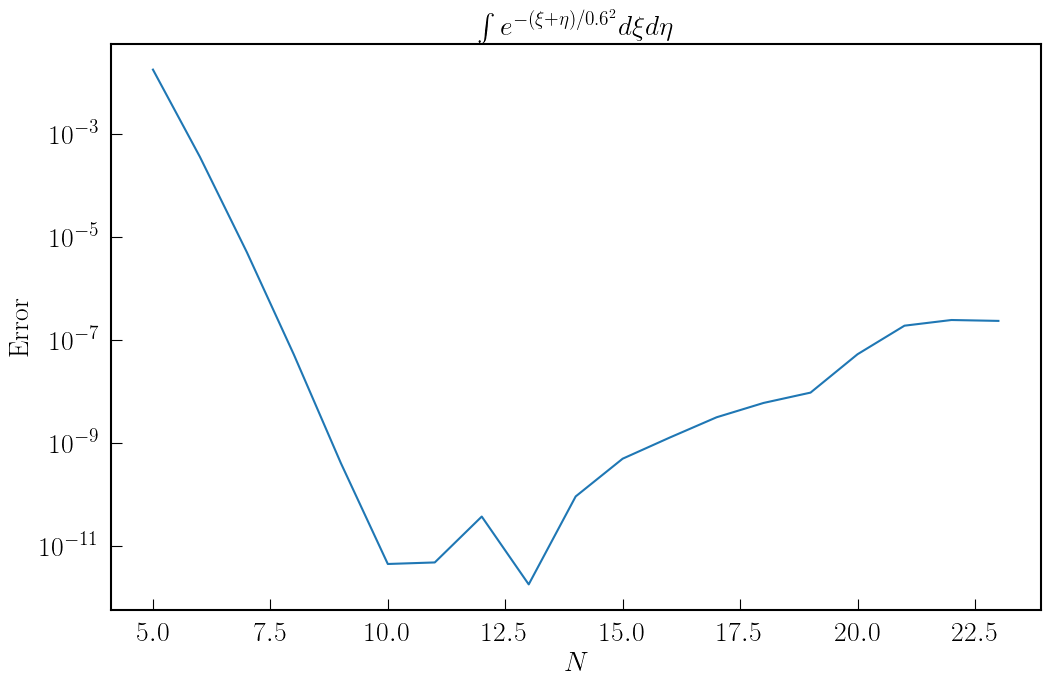

In [75]:
plt.title(r'$\int e^{-(\xi + \eta) / 0.6^2} d\xi d\eta$')
plt.xlabel(r'$N$')
plt.ylabel(r'Error')
plt.semilogy(np.arange(5, 24, dtype = np.int), error, )

plt.savefig('integrate_2d.png')
plt.show()